In [18]:
### Import Packages ###
import glob, os, sys
import numpy as np
import matplotlib.pyplot as plt


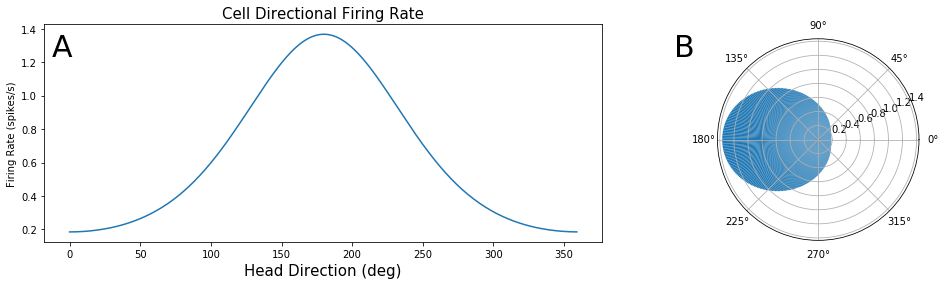

In [19]:
### Generate the ground-truth Von Mises distribution for firing rate preference ###
from scipy.stats import vonmises

#Von MisesSet-up
kappa = 1.0
circMean = np.pi 
stdev = 1.0 #1.0 is default

#Scaling factor of the probability of firing
scale_factor = 4.0 #Had it at 4.5 before


### Visualization ###

## Visualize on a cartesian plot
vis_prob = vonmises.pdf(np.linspace(0,2*np.pi, num=360, endpoint=False), kappa, loc=circMean, scale=stdev)
plt.figure(figsize=(10,4))
plt.plot(vis_prob * scale_factor)
plt.title("Cell Directional Firing Rate", fontsize=15)
plt.xlabel("Head Direction (deg)", fontsize=15)
plt.ylabel("Firing Rate (spikes/s)")
plt.text(0.135, 0.77, "A", fontsize=30, transform=plt.gcf().transFigure)

ax_polar = plt.gcf().add_axes([0.85, 0.13, 0.7, 0.7], polar=True)
ax_polar.bar(np.linspace(0.0, 2*np.pi, 360, endpoint=False), vis_prob*scale_factor, width=((2*np.pi)/360))
plt.text(1.0, 0.77, "B", fontsize=30, transform=plt.gcf().transFigure)
plt.show()

Simulated head direction subset:


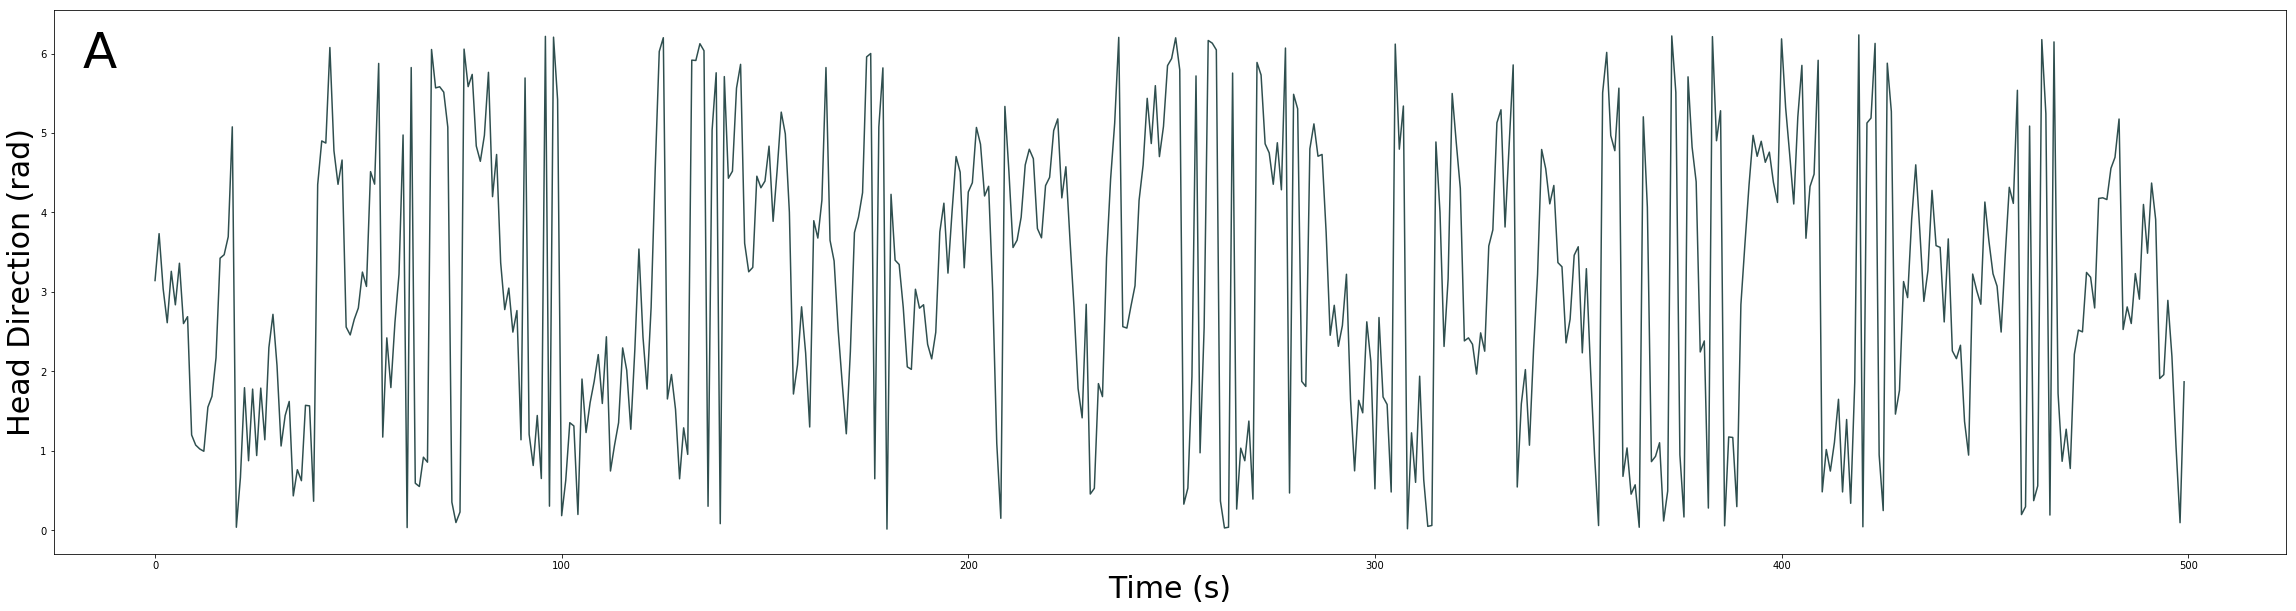

Simulated spiking histogram subset:


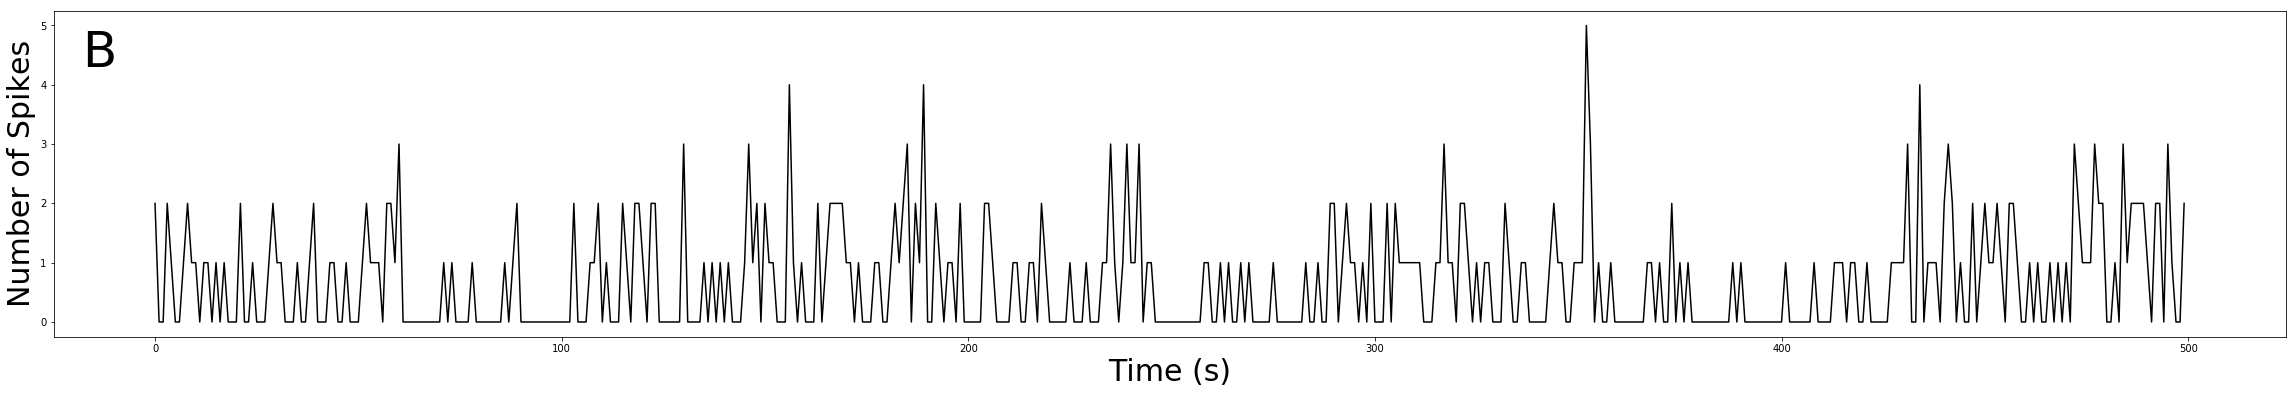

In [20]:
### Generate the Gaussian Random Walk and simualte the firing rate ###

#Number of head direction directions to generate
N_HD = 100000

#Simulate a gaussian walk starting from radian = pi
gaussian_walk = [np.pi] * N_HD
for i in range(1,N_HD):
    gaussian_walk[i] = np.random.normal(loc=gaussian_walk[i-1])
#Bound the head angles to within 2 pi
simulated_rads = np.mod(gaussian_walk, (2*np.pi))

#Visualize the direction
print("Simulated head direction subset:")
plt.figure(figsize=(40,10))
plt.plot(simulated_rads[0:500], color='darkslategray')
plt.xlabel("Time (s)", fontsize=30)
plt.ylabel("Head Direction (rad)", fontsize=30)
plt.text(0.135, 0.8, "A", fontsize=50, transform=plt.gcf().transFigure)
plt.show()

#Simulate the expected firing probability with the same parameters and scale 
tr_prob_firing = vonmises.pdf(simulated_rads, kappa, loc=circMean, scale=stdev)
tr_expected_numSpks = tr_prob_firing * scale_factor

#Sample from poisson to get the cross-validation spike events
tr_numSpks_perFrame = np.random.poisson(lam=tr_expected_numSpks)

print("Simulated spiking histogram subset:")
plt.figure(figsize=(40,6))
plt.plot(tr_numSpks_perFrame[0:500],color='black')
plt.xlabel("Time (s)", fontsize=30)
plt.ylabel("Number of Spikes", fontsize=30)
plt.text(0.135, 0.75, "B", fontsize=50, transform=plt.gcf().transFigure)
plt.show()

Smoothed, then Divide:


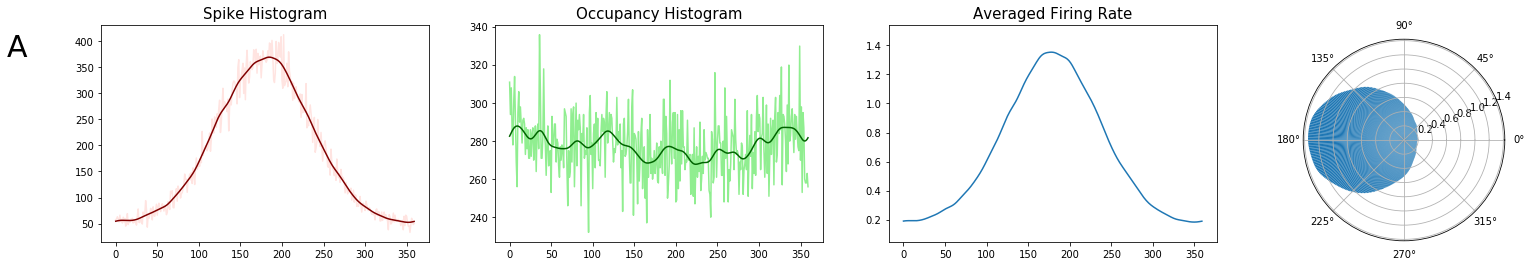

Divided, then Smooth:


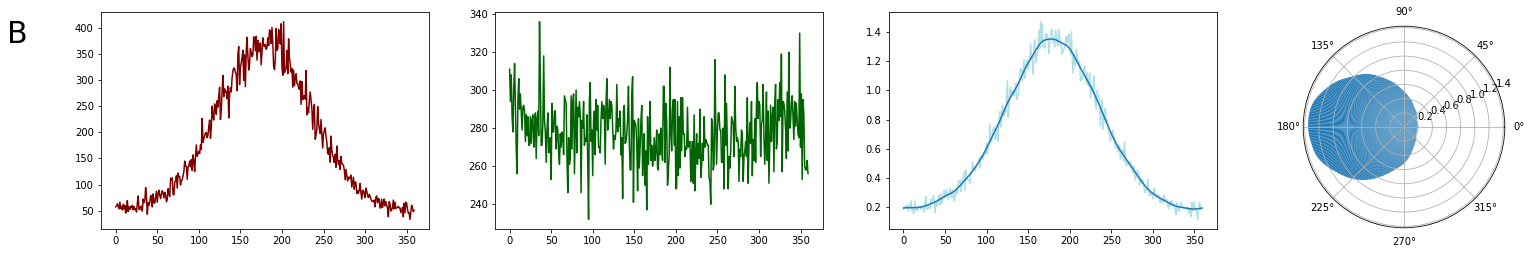

In [21]:
### Smoothing and computing the HD field ###
from scipy import ndimage

#Compute the spike angle histogram and smooth
spkAngs_hist = np.histogram(simulated_rads, bins=360, range=(0,2*np.pi),weights=tr_numSpks_perFrame)[0].astype(float)
spkAngs_hist_smoothed = ndimage.filters.gaussian_filter(spkAngs_hist,6,mode='wrap')

#Compute the total time spent in each angle and smooth
hdAngs_hist = np.histogram(simulated_rads, bins=360, range=(0,2*np.pi),weights=None)[0].astype(float)
hdAngs_hist_smoothed = ndimage.filters.gaussian_filter(hdAngs_hist,6,mode='wrap')

#Compute the firing rate (unit: time per HD recording frame)
HDfield_preSmoothed = np.divide(spkAngs_hist_smoothed,hdAngs_hist_smoothed)
HDfield_postSmoothed_raw = np.divide(spkAngs_hist,hdAngs_hist)
HDfield_postSmoothed = ndimage.filters.gaussian_filter(HDfield_postSmoothed_raw,6,mode='wrap')


## Visualize pre-smoothed data ##
print("Smoothed, then Divide:")
fig, preAx = plt.subplots(1,3)
fig.set_figwidth(20)
preAx[0].set_title("Spike Histogram", fontsize=15)
preAx[0].plot(spkAngs_hist,color='mistyrose')
preAx[0].plot(spkAngs_hist_smoothed, color='maroon')
preAx[1].set_title("Occupancy Histogram", fontsize=15)
preAx[1].plot(hdAngs_hist,color='lightgreen')
preAx[1].plot(hdAngs_hist_smoothed,color='darkgreen')
preAx[2].set_title("Averaged Firing Rate", fontsize=15)
preAx[2].plot(HDfield_postSmoothed_raw, color='white')
preAx[2].plot(HDfield_preSmoothed,color='#1f77b4')
#Viualize polar axis
polar_ax = fig.add_axes([0.68, 0.13, 0.7, 0.7], polar=True)
polar_ax.bar(np.linspace(0.0,2*np.pi,360,endpoint=False), HDfield_preSmoothed, width=((2.0*np.pi)/360.0))
fig.text(0.06, 0.77, "A", fontsize=30, transform=plt.gcf().transFigure)
plt.show()

## Visualize post-smootedh data ##
print("Divided, then Smooth:")
fig, postAx = plt.subplots(1,3)
fig.set_figwidth(20)
postAx[0].plot(spkAngs_hist,color='maroon')
postAx[1].plot(hdAngs_hist,color='darkgreen')
postAx[2].plot(HDfield_postSmoothed_raw, color='powderblue')
postAx[2].plot(HDfield_postSmoothed, color='#1f77b4')
#Visualize polar axis
polar_ax = fig.add_axes([0.68, 0.13, 0.7, 0.7], polar=True)
polar_ax.bar(np.linspace(0.0,2*np.pi,360,endpoint=False), HDfield_postSmoothed, width=((2.0*np.pi)/360.0))
fig.text(0.06, 0.77, "B", fontsize=30, transform=plt.gcf().transFigure)
plt.show()


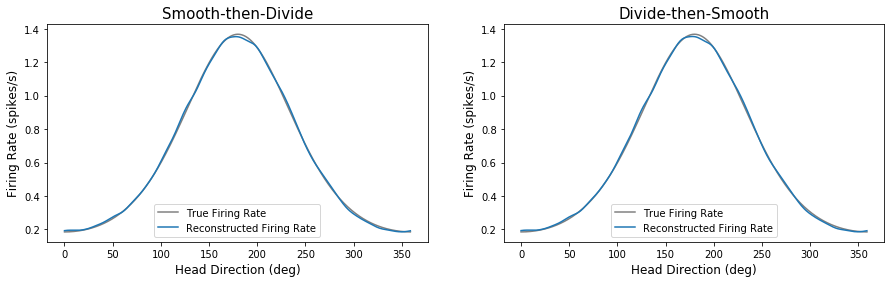

In [22]:
## Visualize Re-created field with expected (perfect) field ##

#Create the expected average firing rate
HDfield_expected = vis_prob * scale_factor

#Visualize
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
ax[0].plot(HDfield_expected,color='gray')
ax[0].plot(HDfield_preSmoothed)
ax[0].set_title("Smooth-then-Divide",fontsize=15)
ax[0].set_xlabel("Head Direction (deg)", fontsize=12)
ax[0].set_ylabel("Firing Rate (spikes/s)", fontsize=12)
ax[0].legend(['True Firing Rate','Reconstructed Firing Rate'])

ax[1].plot(HDfield_expected,color='gray')
ax[1].plot(HDfield_postSmoothed)
ax[1].set_title("Divide-then-Smooth",fontsize=15)
ax[1].set_xlabel("Head Direction (deg)", fontsize=12)
ax[1].set_ylabel("Firing Rate (spikes/s)", fontsize=12)
ax[1].legend(['True Firing Rate','Reconstructed Firing Rate'])
plt.show()


In [23]:
## Generated a distribution to difference ##

N_SAMPLE = 1000

N_HD_perSample = 10000

from scipy import ndimage

sqrErrors_preSmoothed = [0.0] * N_SAMPLE
sqrErrors_postSmoothed = [0.0] * N_SAMPLE

## Simualte Head Directions ##
#Simulate a gaussian walk starting from radian = pi
gaussian_walk = [np.pi] * N_HD_perSample
for i in range(1,N_HD_perSample):
    gaussian_walk[i] = np.random.normal(loc=gaussian_walk[i-1])
#Bound the head angles to within 2 pi
simulated_rads = np.mod(gaussian_walk, (2*np.pi))

#Simulate the expected firing probability with the same parameters and scale 
tr_prob_firing = vonmises.pdf(simulated_rads, kappa, loc=circMean, scale=stdev)
tr_expected_numSpks = tr_prob_firing * scale_factor


#Generate samples
for nth_sample in range(0,N_SAMPLE):
    ### Simulate Spiking ###
    #Sample from poisson to get the cross-validation spike events
    tr_numSpks_perFrame = np.random.poisson(lam=tr_expected_numSpks)

    ### Simualte head direction field reconstruction ###
    #Compute the spike angle histogram and smooth
    spkAngs_hist = np.histogram(simulated_rads, bins=360, range=(0,2*np.pi),weights=tr_numSpks_perFrame)[0].astype(float)
    spkAngs_hist_smoothed = ndimage.filters.gaussian_filter(spkAngs_hist,6,mode='wrap')

    #Compute the total time spent in each angle and smooth
    hdAngs_hist = np.histogram(simulated_rads, bins=360, range=(0,2*np.pi),weights=None)[0].astype(float)
    hdAngs_hist_smoothed = ndimage.filters.gaussian_filter(hdAngs_hist,6,mode='wrap')

    #Compute the firing rate (unit: time per HD recording frame)
    HDfield_preSmoothed = np.divide(spkAngs_hist_smoothed,hdAngs_hist_smoothed)
    HDfield_postSmoothed_raw = np.divide(spkAngs_hist,hdAngs_hist)
    HDfield_postSmoothed = ndimage.filters.gaussian_filter(HDfield_postSmoothed_raw,6,mode='wrap')
    
    
    ### Compute Difference between reconstructed and perfect ###
    HDfield_expected =  vonmises.pdf(np.linspace(0,2*np.pi, num=360, endpoint=False), kappa, loc=circMean, scale=stdev) * scale_factor   
    #Compute difference
    diff_preSmoothed = np.subtract(HDfield_preSmoothed,HDfield_expected)
    diff_postSmoothed = np.subtract(HDfield_postSmoothed,HDfield_expected)
    #Compute squarred error
    sqErr_preSmoothed = np.dot(diff_preSmoothed,diff_preSmoothed) #/ 360.0
    sqErr_postSmoothed = np.dot(diff_postSmoothed,diff_postSmoothed)# / 360.0
    
    ## Add to array
    sqrErrors_preSmoothed[nth_sample] = sqErr_preSmoothed
    sqrErrors_postSmoothed[nth_sample] = sqErr_postSmoothed
    

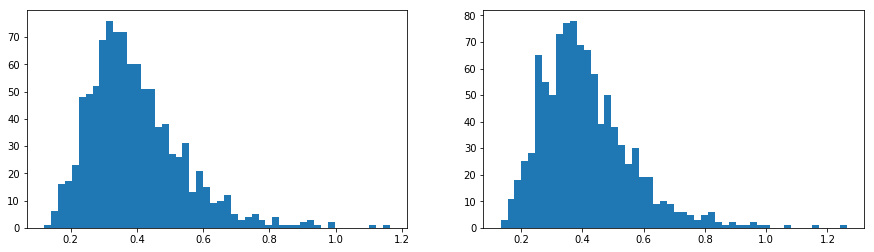

0.01328


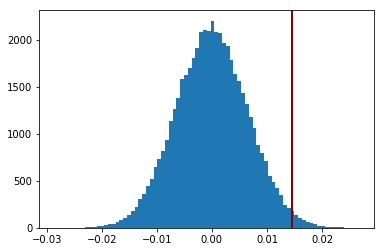

In [24]:
### Test for difference between two groups ###


## Initial visualization ##
fig, ax = plt.subplots(1,2)
fig.set_figwidth(15)
ax[0].hist(sqrErrors_preSmoothed, bins=50)
ax[1].hist(sqrErrors_postSmoothed, bins=50)
plt.show()


## Permutation testing ##
N_PERMUTE = 50000

#Compute the mean difference between the two groups (postSmoothed - preSmoothed)
mean_diff = np.mean(sqrErrors_postSmoothed) - np.mean(sqrErrors_preSmoothed)

#Combine data, take length & initialize array for permuted null difference
combined_sqrErrors = np.concatenate((sqrErrors_preSmoothed,sqrErrors_postSmoothed))
midIdx_sqrErrors = len(combined_sqrErrors)//2
null_distri = [0.0] * N_PERMUTE

#Permutate data
for nth_permute in range(0,N_PERMUTE):
    #Randomly sample from the combined distribution
    shuffled_sqrErrors = np.random.permutation(combined_sqrErrors)
    
    #Take the difference between the squared errors
    permuted_diff = np.mean(shuffled_sqrErrors[:midIdx_sqrErrors]) - np.mean(shuffled_sqrErrors[midIdx_sqrErrors:])
    
    #Add to null distribution
    null_distri[nth_permute] = permuted_diff

#Calculate p value
p_alternative = float(sum(null_distri > mean_diff)) / N_PERMUTE
print(p_alternative)

#Visualize
plt.hist(null_distri,bins=80)
plt.axvline(x=mean_diff, color='darkred', linestyle='-',linewidth=2)
plt.show()


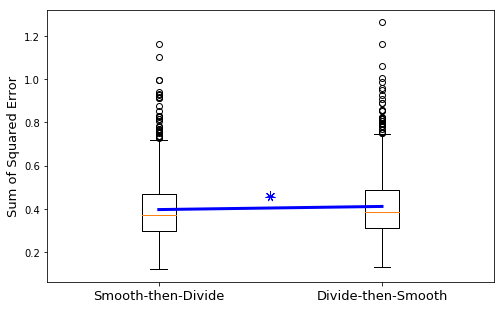

In [53]:
## Plot test comparison ##

#Plot boxplots
plt.figure(figsize=(8,5))
plt.boxplot([sqrErrors_preSmoothed, sqrErrors_postSmoothed])

#Plot mean
preSmooth_mean = np.mean(sqrErrors_preSmoothed)
postSMooth_mean = np.mean(sqrErrors_postSmoothed)
plt.plot([1,2],[preSmooth_mean,postSMooth_mean], linewidth=3, color='blue')

#Plot significant
plt.plot(1.5, 0.46,marker=(7, 2), color='blue', markersize=10)


#Labels and show
plt.ylabel("Sum of Squared Error", fontsize=13)
plt.xticks([1,2], ['Smooth-then-Divide','Divide-then-Smooth'], fontsize=13)
plt.show()